In [1]:
import os
import time
from utils import *

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="white")

# from sklearn import manifold, cluster, metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GlobalAveragePooling1D

from transformers import *

from nltk.tokenize import word_tokenize
import gensim

c:\Users\gabriel.chehade\Documents\Projets\Github\Item-Classification\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\gabriel.chehade\Documents\Projets\Github\Item-Classification\.venv\Lib\site-packages\transformers\deepspeed.py:23: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(
c:\Users\gabriel.chehade\Documents\Projets\Github\Item-Classification\.venv\Lib\site-packages\transformers\generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(


In [2]:
df_text = pd.read_csv("data/df_text.csv", index_col=0)
print(df_text.shape)
df_text.head()

(1050, 5)


,text,category,clean_text,clean_text_lem,clean_text_stem
0,Elegance Polyester Multicolor Abstract Eyelet ...,Home Furnishing,elegance polyester multicolor abstract eyelet ...,elegance polyester multicolor abstract eyelet ...,eleg polyest multicolor abstract eyelet door c...
1,Sathiyas Cotton Bath Towel Specifications of S...,Baby Care,sathiyas cotton bath towel sathiyas cotton bat...,sathiyas cotton bath towel sathiyas cotton bat...,sathiya cotton bath towel sathiya cotton bath ...
2,Eurospa Cotton Terry Face Towel Set Key Featur...,Baby Care,eurospa cotton terry face towel set key eurosp...,eurospa cotton terry face towel set key eurosp...,eurospa cotton terri face towel set key eurosp...
3,SANTOSH ROYAL FASHION Cotton Printed King size...,Home Furnishing,santosh royal fashion cotton printed king size...,santosh royal fashion cotton printed king size...,santosh royal fashion cotton print king size d...
4,Jaipur Print Cotton Floral King sized Double B...,Home Furnishing,jaipur print cotton floral king sized double b...,jaipur print cotton floral king sized double b...,jaipur print cotton floral king size doubl bed...


# Bag of words

## Comtage simple

In [3]:
# Paramètres
text = "clean_text_lem"  # colonne utilisée pour le bag of words
categories = list(df_text["category"].unique())  # liste des catégories
n_labels = len(categories)
# étiquetage des points selon leur catégorie
cat_labels = df_text["category"].apply(lambda x: categories.index(x)).values

In [4]:
# création du bag of words
cvect = CountVectorizer(max_df=0.95, min_df=1, stop_words="english")
X_bow = cvect.fit_transform(df_text[text])

# Réduction de dimensionnalité
pca = PCA(n_components=0.99, random_state=0)
print("Dimensions du dataset avant réduction PCA :", X_bow.shape)
X_bow_pca = pca.fit_transform(X_bow.toarray())
print("Dimensions du dataset après réduction PCA : ", X_bow_pca.shape)
print(
    "Pourcentage de la variance expliquée : %.1f"
    % (100 * pca.explained_variance_ratio_.sum())
)
print()

# TSNE et clustering
print()
print("t-SNE et clustering")
print("-----------------")
print("Données non-réduites :")
ARI_bow, X_bow_tsne, labels_bow = ARI_fct(X_bow, n_labels, cat_labels)
print("Données réduites :")
ARI_bow_pca, X_bow_pca_tsne, labels_bow_pca = ARI_fct(X_bow_pca, n_labels, cat_labels)

Dimensions du dataset avant réduction PCA : (1050, 3206)
Dimensions du dataset après réduction PCA :  (1050, 634)
Pourcentage de la variance expliquée : 99.0


t-SNE et clustering
-----------------
Données non-réduites :
ARI :  0.44 duration :  18.3 s
Données réduites :
ARI :  0.47 duration :  17.1 s


En appliquant une ACP à 99% de variance expliquée sur les données avant d'effectuer la réduction de dimension t-SNE, on obtient un meilleur ARI et en un temps plus court.

## Visualisation

In [5]:
# On échange les numéro de certains clusters pour mieux comparer visuellement
switch(labels_bow_pca, 0, 5)
switch(labels_bow_pca, 1, 3)
switch(labels_bow_pca, 4, 5)
switch(labels_bow_pca, 5, 6)

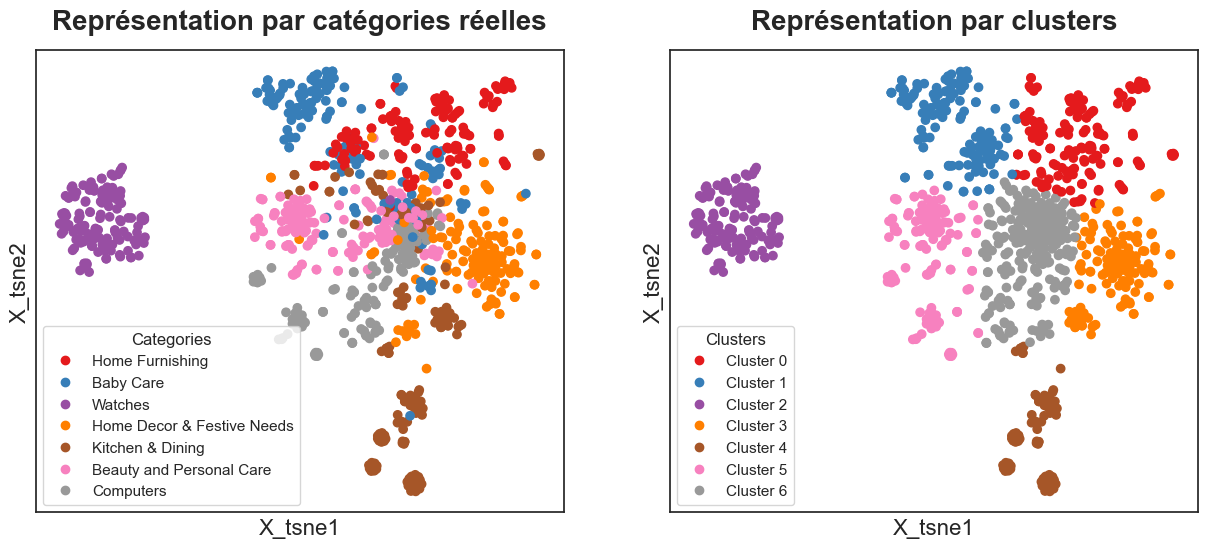

ARI :  0.47


In [6]:
TSNE_visu_fct(X_bow_pca_tsne, cat_labels, labels_bow_pca, categories, ARI_bow_pca)

## TF-IDF

In [7]:
# création du bag of words
ctf = TfidfVectorizer(max_df=0.95, min_df=1, stop_words="english")
X_tfidf = ctf.fit_transform(df_text[text])

# Réduction de dimensionnalité
pca = PCA(n_components=0.99, random_state=0)
print("Dimensions dataset avant réduction PCA :", X_tfidf.shape)
X_tfidf_pca = pca.fit_transform(X_tfidf.toarray())
print("Dimensions dataset après réduction PCA : ", X_tfidf_pca.shape)
print(
    "Pourcentage de la variance expliquée : %.1f"
    % (100 * pca.explained_variance_ratio_.sum())
)
print()

# TSNE et clustering
print("t-SNE et clustering ")
print("--------")
print("Données non-réduites :")
ARI_tfidf, X_tfidf_tsne, labels_tfidf = ARI_fct(X_tfidf, n_labels, cat_labels)
print("Données réduites :")
ARI_tfidf_pca, X_tfidf_pca_tsne, labels_tfidf_pca = ARI_fct(
    X_tfidf_pca, n_labels, cat_labels
)

Dimensions dataset avant réduction PCA : (1050, 3206)
Dimensions dataset après réduction PCA :  (1050, 773)
Pourcentage de la variance expliquée : 99.0

t-SNE et clustering 
--------
Données non-réduites :
ARI :  0.57 duration :  14.0 s
Données réduites :
ARI :  0.5 duration :  14.5 s


Cette fois, les résultats sont moins bons lorsqu'on réduit les dimensions avec une ACP.

In [8]:
# On échange les numéro de certains clusters pour mieux comparer visuellement
switch(labels_tfidf, 0, 4)
switch(labels_tfidf, 1, 4)
switch(labels_tfidf, 2, 3)
switch(labels_tfidf, 3, 6)
switch(labels_tfidf, 4, 5)
switch(labels_tfidf, 5, 6)

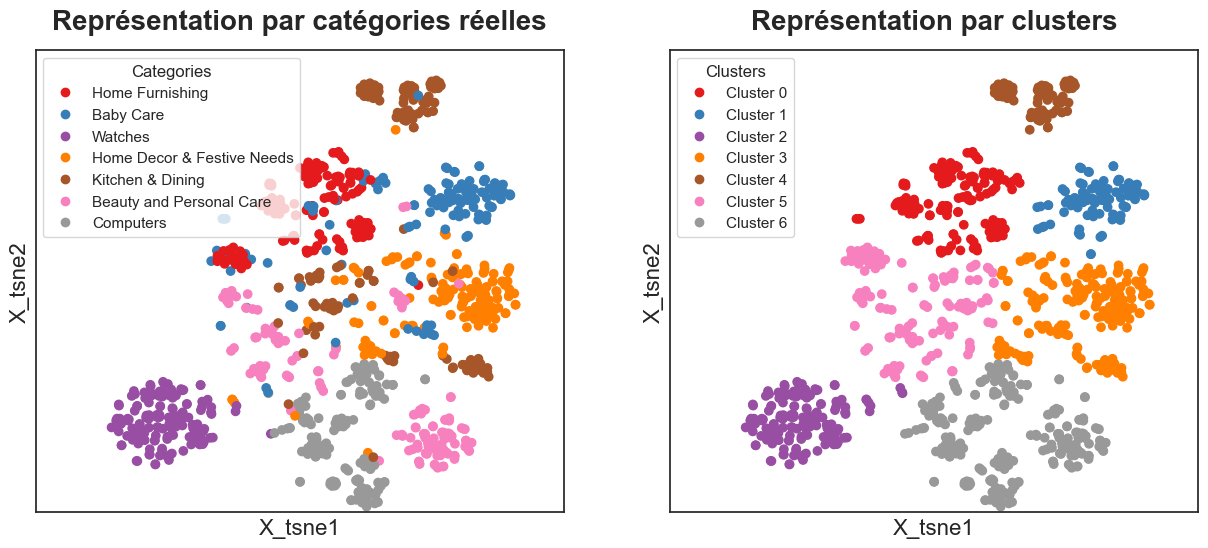

ARI :  0.57


In [9]:
TSNE_visu_fct(
    X_tfidf_tsne,
    cat_labels,
    labels_tfidf,
    categories,
    ARI_tfidf,
    xlim=(-70, 50),
    ylim=(-60, 80),
)

## Classification

On va entraîné un modèle de classification standard pour voir si on obtient des résultats satisfaisants avec le preprocessing qu'on a effectué. On va utiliser ici un modèle de régression logistique.

In [10]:
# Pour le comptage simple
X_train, X_test, y_train, y_test = train_test_split(
    X_bow, cat_labels, test_size=0.2, random_state=2024
)
print(f"X_train shape : {X_train.shape}, y_train shape : {y_train.shape}")
print(f"X_test shape : {X_test.shape}, y_test shape : {y_test.shape}")
print()

logreg = LogisticRegression(C=0.1, max_iter=1000)
logreg.fit(X_train, y_train)

print("Results of the Logistic Regression :")
print("Accuracy on training set : %.3f" % logreg.score(X_train, y_train))
print("Accuracy on validation set : %.3f" % logreg.score(X_test, y_test))

X_train shape : (840, 3206), y_train shape : (840,)
X_test shape : (210, 3206), y_test shape : (210,)

Results of the Logistic Regression :
Accuracy on training set : 0.993
Accuracy on validation set : 0.919


In [11]:
# Pour le TF-IDF
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, cat_labels, test_size=0.2, random_state=2024
)
print(f"X_train : {X_train.shape}, y_train : {y_train.shape}")
print(f"X_test : {X_test.shape}, y_test : {y_test.shape}")
print()

logreg = LogisticRegression(C=0.1, max_iter=1000)
logreg.fit(X_train, y_train)

print("Results of the Logistic Regression :")
print("Accuracy on training set : %.3f" % logreg.score(X_train, y_train))
print("Accuracy on validation set : %.3f" % logreg.score(X_test, y_test))

X_train : (840, 3206), y_train : (840,)
X_test : (210, 3206), y_test : (210,)

Results of the Logistic Regression :
Accuracy on training set : 0.942
Accuracy on validation set : 0.886


On peut voir que les résultats sont très bons, en particulier pour le comptage simple, le tout avec un modèle simple et sans optimisation des hyper-pramaètres.

# Word2Vec

On regarde le nombre de tokens par documents pour voir à peu près quelle valeur choisir pour le paramètre `max_len` du modèle de Word2Vec.

count    1050.000000
mean       46.574286
std        43.872559
min         3.000000
25%        17.000000
50%        29.000000
75%        64.000000
max       299.000000
Name: clean_text, dtype: float64


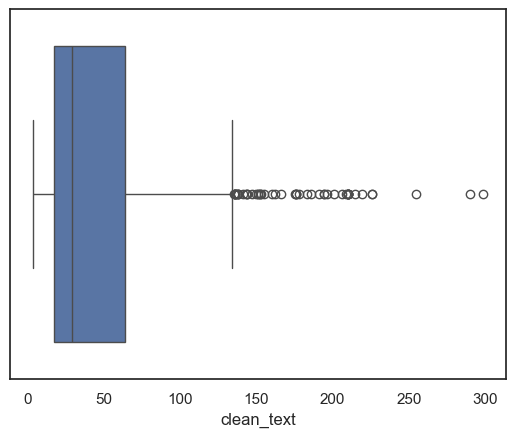

In [12]:
text = "clean_text"
num_tokens = df_text[text].apply(word_tokenize)
num_tokens = num_tokens.apply(lambda x: len(x))
print(num_tokens.describe())

sns.boxplot(x=num_tokens)
plt.show()

## Analyse

In [13]:
def word2vec_evaluation(
    documents,
    max_len,
    preprocess=False,
    w2v_size=300,
    window=5,
    min_count=1,
    epochs=100,
):
    """
    Evaluation function for the Word2Vec model
    """

    # tokenization des documents
    if preprocess == True:
        documents = [gensim.utils.simple_preprocess(text) for text in documents]
    else:
        documents = [doc.split(" ") for doc in documents]

    # Création et entraînement du modèle Word2Vec
    start = time.time()
    print("Build & train Word2Vec model ...")
    w2v_model = gensim.models.Word2Vec(
        min_count=min_count,
        window=window,
        vector_size=w2v_size,
        seed=42,
        workers=1,
        # workers=multiprocessing.cpu_count()
    )
    w2v_model.build_vocab(documents)
    w2v_model.train(documents, total_examples=w2v_model.corpus_count, epochs=epochs)
    end = time.time()
    print("Word2Vec trained")
    print("Duration : %.2f s" % (end - start))

    # Récupération des vecteurs
    model_vectors = w2v_model.wv
    w2v_words = model_vectors.index_to_key  # Vocabulaire du corpus
    print(f"Vocabulary size: {len(w2v_words)}")
    print()

    # Transformation des tokens en séquences
    print("Fit Tokenizer ...")
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(documents)

    num_words = len(tokenizer.word_index)
    print("Number of unique words: %i" % num_words)
    print()

    # Padding des documents
    x_documents = pad_sequences(
        tokenizer.texts_to_sequences(documents),
        maxlen=max_len,  # longueur maximale des sequences
        padding="post",
    )

    # Création de la matrice d'embedding
    print("Create Embedding matrix ...")
    word_index = tokenizer.word_index
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, w2v_size))
    i = 0
    j = 0
    for word, idx in word_index.items():
        i += 1
        if word in w2v_words:
            j += 1
            # vectorisation du mot
            embedding_vector = model_vectors[word]
            if embedding_vector is not None:
                embedding_matrix[idx] = model_vectors[word]

    word_rate = np.round(j / i, 4)
    print(f"Word embedding rate : {word_rate}")
    print(f"Embedding matrix shape : {embedding_matrix.shape}")
    print()

    # Création du modèle d'embedding
    print("Create Embedding model ...")
    # x_input = Input(shape=(len(x_documents), max_len), dtype='float64')
    word_input = Input(shape=(max_len,), dtype="float64")
    word_embedding = Embedding(
        input_dim=vocab_size,
        output_dim=w2v_size,
        weights=[embedding_matrix],
        input_length=max_len,
    )(word_input)
    word_vec = GlobalAveragePooling1D()(word_embedding)
    embed_model = Model([word_input], word_vec)

    embed_model.summary()
    print()

    # Exécution du modèle
    print("Execution of the model...")
    X_emb = embed_model.predict(x_documents)
    print()

    return X_emb


documents = df_text[text].to_list()
X_emb = word2vec_evaluation(documents, max_len=150)

Build & train Word2Vec model ...
Word2Vec trained
Duration : 16.50 s
Vocabulary size: 3569

Fit Tokenizer ...
Number of unique words: 3569

Create Embedding matrix ...
Word embedding rate : 1.0
Embedding matrix shape : (3570, 300)

Create Embedding model ...

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150)]             0         
                                                                 
 embedding (Embedding)       (None, 150, 300)          1071000   
                                                                 
 global_average_pooling1d (  (None, 300)               0         
 GlobalAveragePooling1D)                                         
                                                                 
Total params: 1071000 (4.09 MB)
Trainable params: 1071000 (4.09 MB)
Non-trainable params: 0 (0.00 Byte)
___________________________

In [14]:
# t-SNE et clustering
ARI_emb, X_emb_tsne, labels_emb = ARI_fct(X_emb, n_labels, cat_labels)

ARI :  0.58 duration :  14.1 s


## Visualisation

In [15]:
# On échange les numéro de certains clusters pour mieux comparer visuellement
switch(labels_emb, 0, 2)
switch(labels_emb, 1, 5)
switch(labels_emb, 2, 5)
switch(labels_emb, 4, 5)
switch(labels_emb, 5, 6)

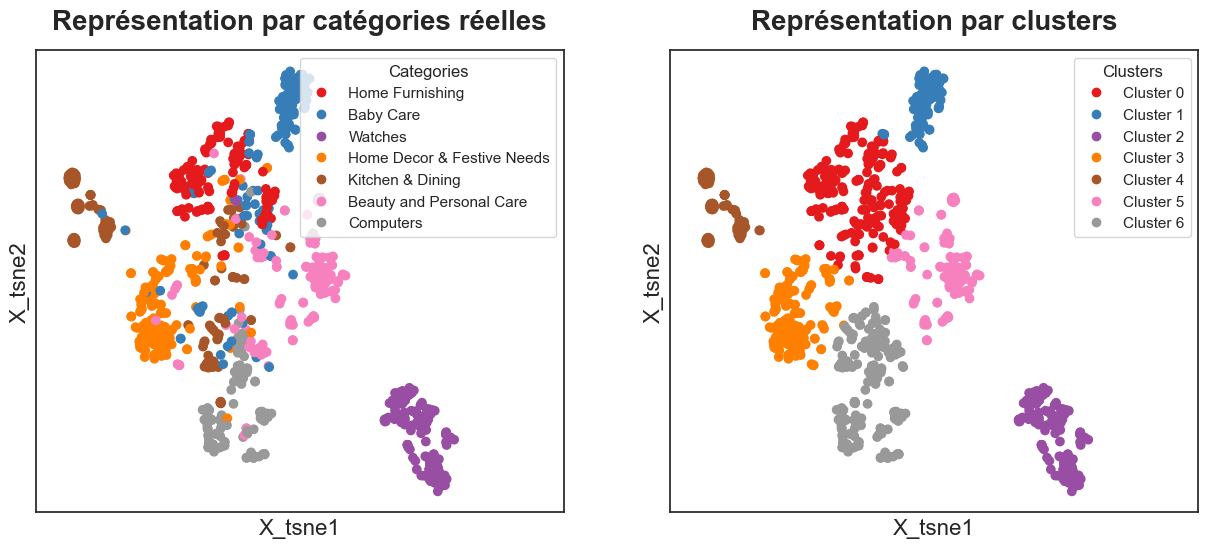

ARI :  0.58


In [16]:
TSNE_visu_fct(
    X_emb_tsne,
    cat_labels,
    labels_emb,
    categories,
    ARI_emb,
    xlim=(-60, 90),
    # show_ticks=True
)

## Classification

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X_emb, cat_labels, test_size=0.2, random_state=2024
)
print(f"X_train : {X_train.shape}, y_train : {y_train.shape}")
print(f"X_test : {X_test.shape}, y_test : {y_test.shape}")
print()

logreg = LogisticRegression(C=0.1, max_iter=1000)
logreg.fit(X_train, y_train)

print("Results of the Logistic Regression :")
print("Accuracy on training set : %.3f" % logreg.score(X_train, y_train))
print("Accuracy on validation set : %.3f" % logreg.score(X_test, y_test))

X_train : (840, 300), y_train : (840,)
X_test : (210, 300), y_test : (210,)

Results of the Logistic Regression :
Accuracy on training set : 0.893
Accuracy on validation set : 0.843


Les résultats sont moins bon qu'avec le comptage simple.

## Comparaison avec les data non nettoyées

count    1050.000000
mean       94.800952
std        84.951965
min        23.000000
25%        42.000000
50%        60.500000
75%       113.750000
max       644.000000
Name: text, dtype: float64


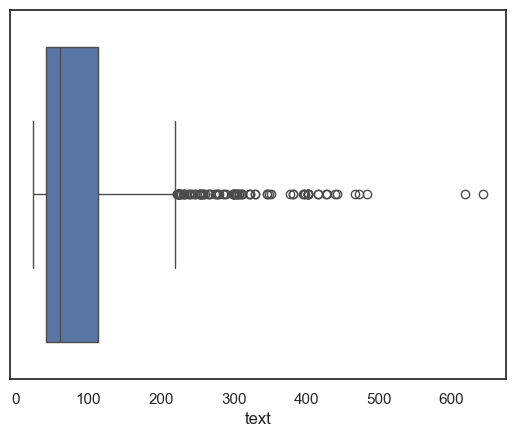

In [18]:
text = "text"
len_text = df_text[text].apply(word_tokenize)
len_text = len_text.apply(lambda x: len(x))
print(len_text.describe())

sns.boxplot(x=len_text)
plt.show()

In [19]:
# text = 'text'
documents = df_text[text].to_list()
X_emb = word2vec_evaluation(
    documents, max_len=300, preprocess=True
)  # this time preprocess=True
ARI_emb, X_emb_tsne, labels_emb = ARI_fct(X_emb, n_labels, cat_labels)

Build & train Word2Vec model ...
Word2Vec trained
Duration : 25.91 s
Vocabulary size: 5192

Fit Tokenizer ...
Number of unique words: 5192

Create Embedding matrix ...
Word embedding rate : 1.0
Embedding matrix shape : (5193, 300)

Create Embedding model ...
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 300, 300)          1557900   
                                                                 
 global_average_pooling1d_1  (None, 300)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
Total params: 1557900 (5.94 MB)
Trainable params: 1557900 (5.94 MB)
Non-trainable params: 0 (0.00 Byte)
__________________________

On voit que l'ARI est beaucoup moins bon : on passe de 0.59 à 0.31

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X_emb, cat_labels, test_size=0.2, random_state=2024
)
print(f"X_train : {X_train.shape}, y_train : {y_train.shape}")
print(f"X_test : {X_test.shape}, y_test : {y_test.shape}")
print()

logreg = LogisticRegression(C=0.1, max_iter=1000)
logreg.fit(X_train, y_train)

print("Results of the Logistic Regression :")
print("Accuracy on training set : %.3f" % logreg.score(X_train, y_train))
print("Accuracy on validation set : %.3f" % logreg.score(X_test, y_test))

X_train : (840, 300), y_train : (840,)
X_test : (210, 300), y_test : (210,)

Results of the Logistic Regression :
Accuracy on training set : 0.856
Accuracy on validation set : 0.824


# BERT

In [21]:
# import logging
# logging.disable(logging.WARNING) # disable WARNING, INFO and DEBUG logging everywhere

# os.environ["TF_KERAS"] = '1'

In [22]:
print("tf version :", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices("GPU")))

tf version : 2.15.0
Num GPUs Available:  0


## Fonctions communes

In [23]:
from tqdm import tqdm


# Fonction de préparation des documents
def bert_inp_fct(documents, bert_tokenizer, max_length):
    """
    Function that returns the inputs for BERT model
    """
    input_ids = []
    token_type_ids = []
    attention_mask = []

    for doc in documents:
        bert_inp = bert_tokenizer.encode_plus(
            doc,
            add_special_tokens=True,
            max_length=max_length,
            padding="max_length",
            return_attention_mask=True,
            return_token_type_ids=True,
            truncation=True,
            return_tensors="tf",
        )

        input_ids.append(bert_inp["input_ids"][0])
        token_type_ids.append(bert_inp["token_type_ids"][0])
        attention_mask.append(bert_inp["attention_mask"][0])

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.asarray(attention_mask)

    return input_ids, token_type_ids, attention_mask


# Fonction de création des features
def feature_BERT_fct(model, model_type, documents, max_length, batch_size, mode="HF"):
    # Calcul du nombre de batches
    quotient = len(documents) // batch_size
    remainder = len(documents) % batch_size
    if remainder == 0:
        n_batches = quotient
    else:
        n_batches = quotient + 1

    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)

    start = time.time()
    for step in tqdm(range(n_batches)):
        idx = step * batch_size
        if step < quotient:
            b_size = batch_size
        else:
            b_size = remainder

        input_ids, token_type_ids, attention_mask = bert_inp_fct(
            documents[idx : idx + b_size], bert_tokenizer, max_length
        )

        if mode == "HF":  # Bert from HuggingFace
            outputs = model.predict(
                [input_ids, attention_mask, token_type_ids],
                batch_size=b_size,
                verbose=0,
            )
            last_hidden_states = outputs.last_hidden_state

        if mode == "TFhub":  # Bert from Tensorflow Hub
            text_preprocessed = {
                "input_word_ids": input_ids,
                "input_mask": attention_mask,
                "input_type_ids": token_type_ids,
            }
            outputs = model(text_preprocessed)
            last_hidden_states = outputs["sequence_output"]

        if step == 0:
            last_hidden_states_tot = last_hidden_states
        else:
            last_hidden_states_tot = np.concatenate(
                (last_hidden_states_tot, last_hidden_states)
            )

    features_bert = np.array(last_hidden_states_tot).mean(axis=1)

    end = time.time()
    print("Duration : ", np.round(end - start, 0), "s")

    return features_bert, last_hidden_states_tot

## BERT from HuggingFace

In [24]:
max_length = 64
batch_size = 10
model_type = "bert-base-uncased"
model = TFAutoModel.from_pretrained(model_type)
documents = df_text["text"].to_list()

# Création des features
features_bert_hf, last_hidden_states_tot = feature_BERT_fct(
    model, model_type, documents, max_length, batch_size, mode="HF"
)

loading configuration file config.json from cache at C:\Users\gabriel.chehade\.cache\huggingface\hub\models--bert-base-uncased\snapshots\1dbc166cf8765166998eff31ade2eb64c8a40076\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.36.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file model.safetensors from cache at C:\Users\gabriel.chehade\.cache\huggingface\hub\models--bert-base-uncased\snapshots\1dbc166cf876

Duration :  111.0 s


In [25]:
ARI_bert_hf, X_bert_hf_tsne, labels_bert_hf = ARI_fct(
    features_bert_hf, n_labels, cat_labels
)

ARI :  0.4 duration :  14.8 s


In [26]:
# On échange les numéro de certains clusters pour mieux comparer visuellement
switch(labels_bert_hf, 0, 5)
switch(labels_bert_hf, 1, 5)
switch(labels_bert_hf, 2, 3)
switch(labels_bert_hf, 3, 4)
switch(labels_bert_hf, 4, 6)
switch(labels_bert_hf, 5, 6)

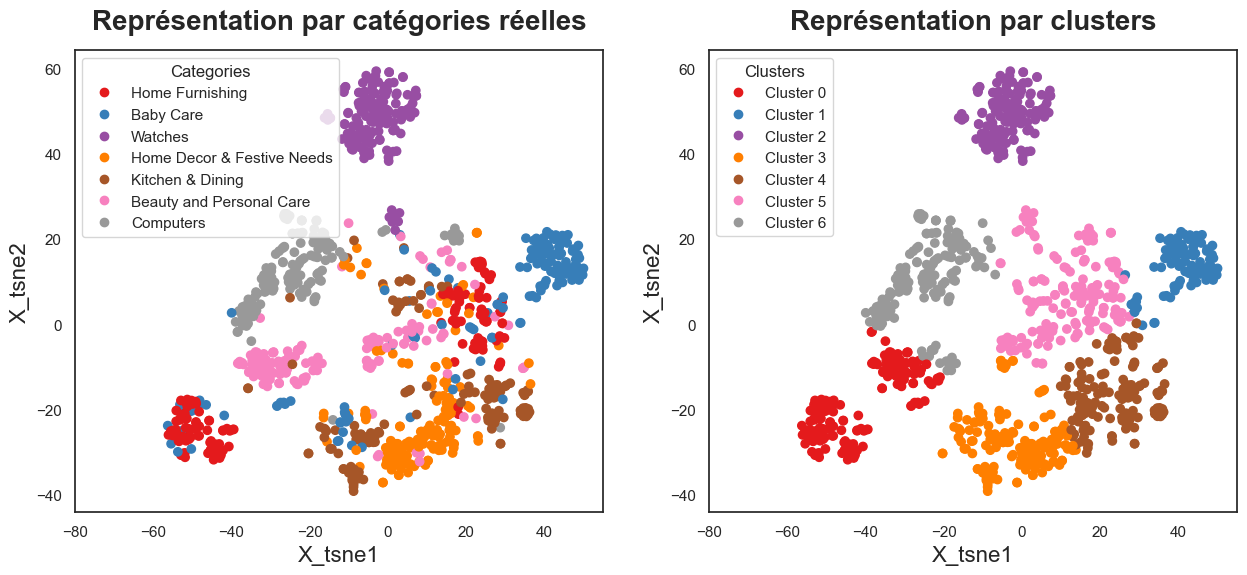

ARI :  0.4


In [27]:
TSNE_visu_fct(
    X_bert_hf_tsne,
    cat_labels,
    labels_bert_hf,
    categories,
    ARI_bert_hf,
    legend_loc="upper left",
    xlim=(-80, 55),
    #   ylim=(-45, 70),
    show_ticks=True,
)

## Classification

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    features_bert_hf, cat_labels, test_size=0.2, random_state=2024
)
print(f"X_train : {X_train.shape}, y_train : {y_train.shape}")
print(f"X_test : {X_test.shape}, y_test : {y_test.shape}")
print()

logreg = LogisticRegression(C=0.1, max_iter=1000)
logreg.fit(X_train, y_train)

print("Results of the Logistic Regression :")
print("Accuracy on training set : %.3f" % logreg.score(X_train, y_train))
print("Accuracy on validation set : %.3f" % logreg.score(X_test, y_test))

X_train : (840, 768), y_train : (840,)
X_test : (210, 768), y_test : (210,)



Results of the Logistic Regression :
Accuracy on training set : 0.961
Accuracy on validation set : 0.914


## BERT from Tensorflow Hub

In [29]:
import tensorflow_hub as hub

model_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"
bert_layer = hub.KerasLayer(model_url, trainable=True)

In [30]:
max_length = 64
batch_size = 10
model_type = "bert-base-uncased"
model = bert_layer
documents = df_text["text"].to_list()

features_bert_tfh, last_hidden_states_tot = feature_BERT_fct(
    model, model_type, documents, max_length, batch_size, mode="TFhub"
)

loading configuration file config.json from cache at C:\Users\gabriel.chehade\.cache\huggingface\hub\models--bert-base-uncased\snapshots\1dbc166cf8765166998eff31ade2eb64c8a40076\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.36.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at C:\Users\gabriel.chehade\.cache\huggingface\hub\models--bert-base-uncased\snapshots\1dbc166cf8765166998eff31ade2

100%|██████████| 105/105 [01:37<00:00,  1.08it/s]


Duration :  97.0 s


In [31]:
ARI_bert_tfh, X_bert_tfh_tsne, labels_bert_tfh = ARI_fct(
    features_bert_tfh, n_labels, cat_labels
)

ARI :  0.43 duration :  15.1 s


In [32]:
# On échange les numéro de certains clusters pour mieux comparer visuellement
switch(labels_bert_tfh, 0, 2)
switch(labels_bert_tfh, 1, 4)
switch(labels_bert_tfh, 2, 3)
switch(labels_bert_tfh, 3, 6)
switch(labels_bert_tfh, 4, 6)

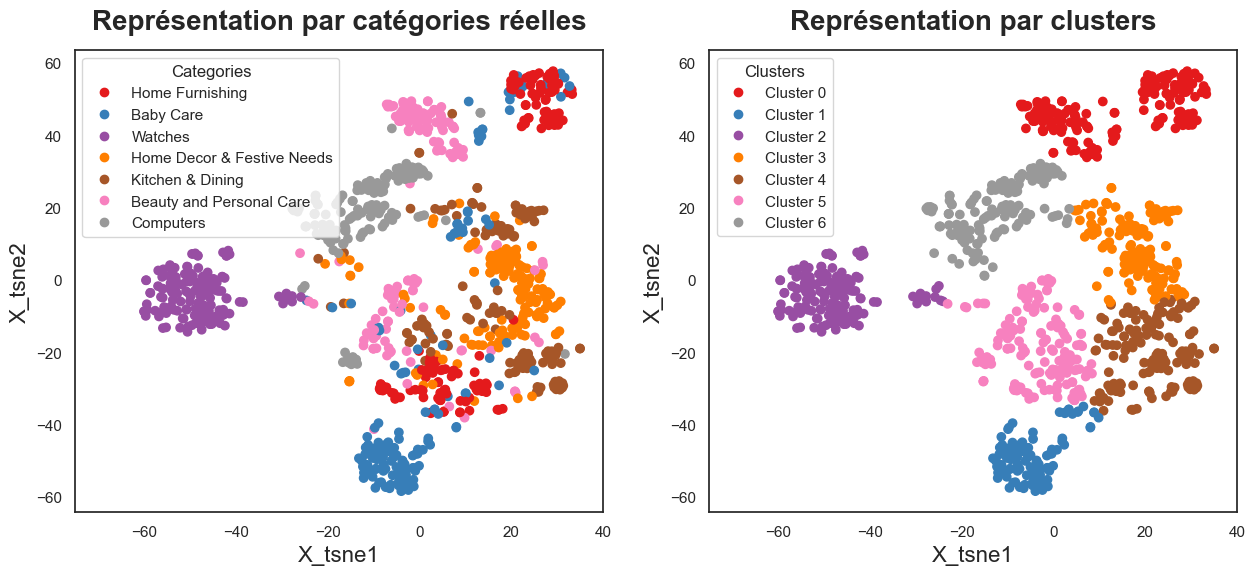

ARI :  0.43


In [33]:
TSNE_visu_fct(
    X_bert_tfh_tsne,
    cat_labels,
    labels_bert_tfh,
    categories,
    ARI_bert_tfh,
    xlim=(-75, 40),
    #   ylim=(-75,65),
    legend_loc="upper left",
    show_ticks=True,
)

## Classification

In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    features_bert_tfh, cat_labels, test_size=0.2, random_state=2024
)
print(f"X_train : {X_train.shape}, y_train : {y_train.shape}")
print(f"X_test : {X_test.shape}, y_test : {y_test.shape}")
print()

logreg = LogisticRegression(C=0.1, max_iter=1000)
logreg.fit(X_train, y_train)

print("Results of the Logistic Regression :")
print("Accuracy on training set : %.3f" % logreg.score(X_train, y_train))
print("Accuracy on validation set : %.3f" % logreg.score(X_test, y_test))

X_train : (840, 768), y_train : (840,)
X_test : (210, 768), y_test : (210,)

Results of the Logistic Regression :
Accuracy on training set : 0.961
Accuracy on validation set : 0.914


# USE - Universal Sentence Encoder

## Analyse

In [35]:
# Cette commande peut prendre plusieurs minutes à s'exécuter la première fois
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [36]:
def feature_USE_fct(documents, batch_size):
    quotient = len(documents) // batch_size
    remainder = len(documents) % batch_size
    if remainder == 0:
        n_batches = quotient
    else:
        n_batches = quotient + 1

    start = time.time()
    for step in range(n_batches):
        idx = step * batch_size
        if step < quotient:
            b_size = batch_size
        else:
            b_size = remainder

        feat = embed(documents[idx : idx + b_size])

        if step == 0:
            features = feat
        else:
            features = np.concatenate((features, feat))

    end = time.time()
    print("duration : ", np.round(end - start, 0), "s")
    return features

In [37]:
batch_size = 10
documents = df_text["text"].to_list()

In [38]:
X_use = feature_USE_fct(documents, batch_size)

duration :  1.0 s


This model is much faster than the BERT model we used before.

In [39]:
ARI_use, X_use_tsne, labels_use = ARI_fct(X_use, n_labels, cat_labels)

ARI :  0.52 duration :  7.5 s


In [40]:
# On échange les numéro de certains clusters pour mieux comparer visuellement
switch(labels_use, 0, 4)
switch(labels_use, 1, 4)
switch(labels_use, 3, 5)
switch(labels_use, 4, 5)

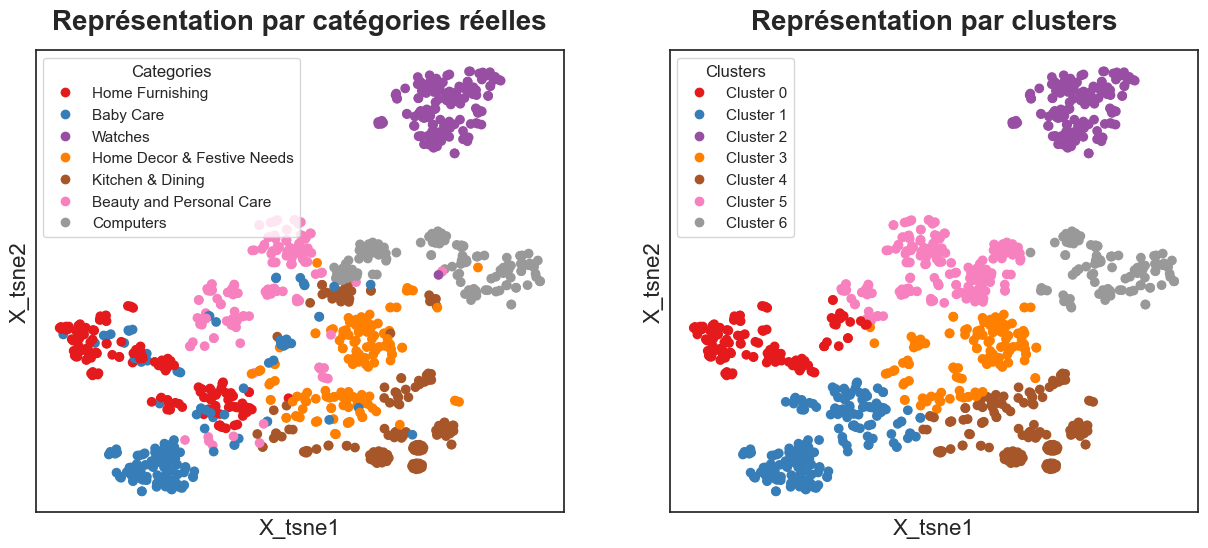

ARI :  0.52


In [41]:
TSNE_visu_fct(
    X_use_tsne,
    cat_labels,
    labels_use,
    categories,
    ARI_use,
    #   xlim=(-75,40), legend_loc='upper left'
)

## Classification

In [42]:
X_train, X_test, y_train, y_test = train_test_split(
    X_use, cat_labels, test_size=0.2, random_state=2024
)
print(f"X_train : {X_train.shape}, y_train : {y_train.shape}")
print(f"X_test : {X_test.shape}, y_test : {y_test.shape}")
print()

logreg = LogisticRegression(C=0.1, max_iter=1000)
logreg.fit(X_train, y_train)

print("Results of the Logistic Regression :")
print("Accuracy on training set : %.3f" % logreg.score(X_train, y_train))
print("Accuracy on validation set : %.3f" % logreg.score(X_test, y_test))

X_train : (840, 512), y_train : (840,)
X_test : (210, 512), y_test : (210,)

Results of the Logistic Regression :
Accuracy on training set : 0.907
Accuracy on validation set : 0.862
